### Importing required libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob


### Data Preprocessing Steps

In [2]:
data = []
labels = []


base_path = 'D:/FALL24/DataMining/Project'  
image_size = (224, 224)  
image_paths = []
label_map = {'benign': 0, 'squamous_cell_carcinoma': 1, 'adenocarcinoma': 2}

for label, label_int in label_map.items():
    folder_path = os.path.join(base_path, label)
    image_paths.extend([(path, label_int) for path in glob(os.path.join(folder_path, '*.jpg'))])

for image_path, label in image_paths:
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, image_size)  
        data.append(image)
        labels.append(label)

data = np.array(data, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

print(f"Loaded {len(data)} images with labels.")


Loaded 15000 images with labels.


In [3]:
print(labels)
print(data)

[0 0 0 ... 2 2 2]
[[[[151.  39.  84.]
   [143.  31.  76.]
   [140.  31.  75.]
   ...
   [215. 202. 228.]
   [211. 203. 229.]
   [205. 202. 227.]]

  [[171.  60. 118.]
   [154.  42.  98.]
   [148.  33.  86.]
   ...
   [217. 204. 230.]
   [210. 203. 228.]
   [206. 203. 228.]]

  [[190.  85. 158.]
   [187.  80. 150.]
   [164.  52. 117.]
   ...
   [214. 201. 227.]
   [211. 203. 228.]
   [207. 204. 229.]]

  ...

  [[155.  33. 110.]
   [155.  44. 137.]
   [163.  63. 184.]
   ...
   [201. 197. 222.]
   [199. 195. 220.]
   [205. 196. 222.]]

  [[155.  38. 118.]
   [157.  47. 144.]
   [154.  54. 176.]
   ...
   [203. 197. 220.]
   [201. 198. 220.]
   [201. 198. 220.]]

  [[174.  71. 154.]
   [176.  78. 174.]
   [153.  60. 176.]
   ...
   [205. 198. 219.]
   [203. 201. 221.]
   [201. 201. 221.]]]


 [[[212. 184. 212.]
   [208. 188. 210.]
   [207. 191. 212.]
   ...
   [206. 203. 210.]
   [207. 205. 211.]
   [207. 205. 212.]]

  [[203. 168. 200.]
   [202. 178. 204.]
   [202. 190. 212.]
   ...
   

##### Image Resize

In [4]:
data_resized = [cv2.resize(img, image_size) for img in data]
data_resized = np.array(data_resized)
print("Images resized to 224x224.")


Images resized to 224x224.


##### Data Normalization

In [5]:
data_normalized = data / 255.0
print("Images normalized to range [0, 1].")
print(data_normalized)


Images normalized to range [0, 1].
[[[[0.5921569  0.15294118 0.32941177]
   [0.56078434 0.12156863 0.29803923]
   [0.54901963 0.12156863 0.29411766]
   ...
   [0.84313726 0.7921569  0.89411765]
   [0.827451   0.79607844 0.8980392 ]
   [0.8039216  0.7921569  0.8901961 ]]

  [[0.67058825 0.23529412 0.4627451 ]
   [0.6039216  0.16470589 0.38431373]
   [0.5803922  0.12941177 0.3372549 ]
   ...
   [0.8509804  0.8        0.9019608 ]
   [0.8235294  0.79607844 0.89411765]
   [0.80784315 0.79607844 0.89411765]]

  [[0.74509805 0.33333334 0.61960787]
   [0.73333335 0.3137255  0.5882353 ]
   [0.6431373  0.20392157 0.45882353]
   ...
   [0.8392157  0.7882353  0.8901961 ]
   [0.827451   0.79607844 0.89411765]
   [0.8117647  0.8        0.8980392 ]]

  ...

  [[0.60784316 0.12941177 0.43137255]
   [0.60784316 0.17254902 0.5372549 ]
   [0.6392157  0.24705882 0.72156864]
   ...
   [0.7882353  0.77254903 0.87058824]
   [0.78039217 0.7647059  0.8627451 ]
   [0.8039216  0.76862746 0.87058824]]

  [[0.6078

##### Displaying Augmented Images

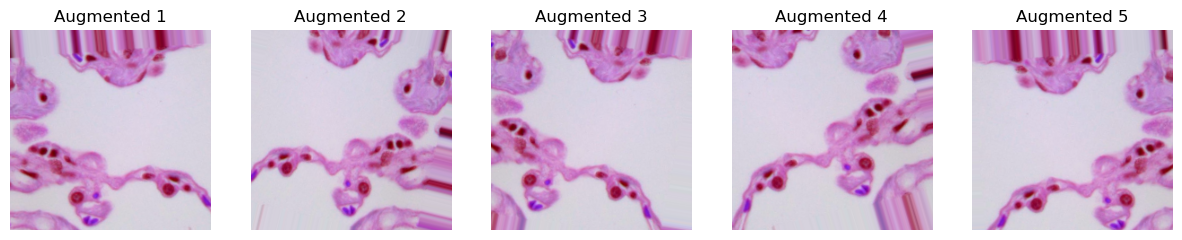

Original image index: 1, Class label: 0


In [6]:
class_id = 0 
class_indices = np.where(labels == class_id)[0]
sample_index = class_indices[1] 
sample_image = data_normalized[sample_index]
sample_image_expanded = np.expand_dims(sample_image, axis=0)


augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

augmented_images = [next(augmenter.flow(sample_image_expanded))[0] for _ in range(5)]
plt.figure(figsize=(15, 5))
for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(aug_img)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')
plt.show()

print(f"Original image index: {sample_index}, Class label: {labels[sample_index]}")


##### Visulizing some of the filters that are using in CNNs

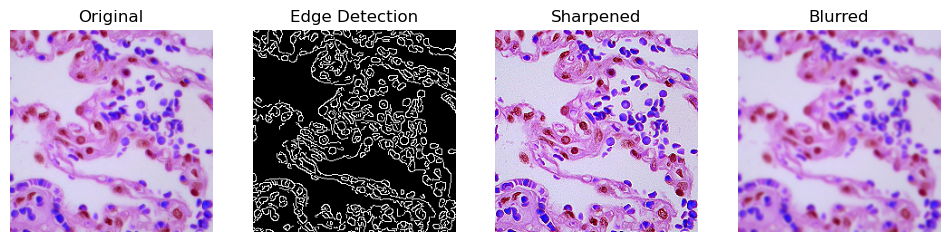

In [7]:
sample_index = 0  
sample_image = data_normalized[sample_index]

# 1. Edge Detection
edge_image = cv2.Canny((sample_image * 255).astype(np.uint8), 100, 200)

# 2. Sharpening
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
sharpened_image = cv2.filter2D((sample_image * 255).astype(np.uint8), -1, kernel)

# 3. Gaussian Blurring
blurred_image = cv2.GaussianBlur((sample_image * 255).astype(np.uint8), (5, 5), 0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(sample_image)
plt.title("Original")
plt.axis('off')


plt.subplot(1, 4, 2)
plt.imshow(edge_image, cmap='gray')
plt.title("Edge Detection")
plt.axis('off')


plt.subplot(1, 4, 3)
plt.imshow(sharpened_image, cmap='gray')
plt.title("Sharpened")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blurred_image, cmap='gray')
plt.title("Blurred")
plt.axis('off')

plt.show()


##### Splitting Data into Training, Testing and Validation sets.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_normalized, labels, test_size=0.2, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (10800, 224, 224, 3), Validation set: (1200, 224, 224, 3), Test set: (3000, 224, 224, 3)


##### Ploting the class distribution

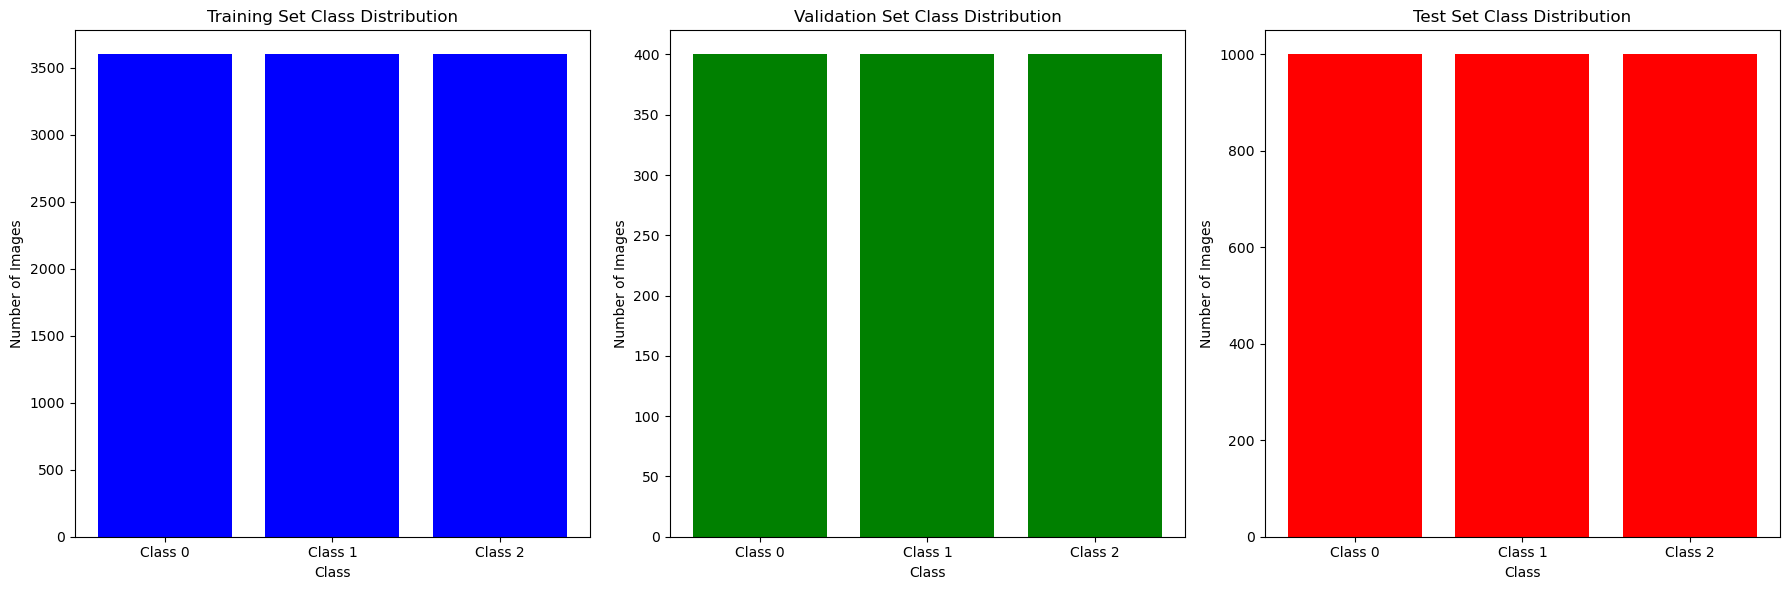

In [9]:
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

class_labels = [f'Class {i}' for i in range(len(train_counts))]


fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, val_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

ax[2].bar(class_labels, test_counts, color='red')
ax[2].set_title('Test Set Class Distribution')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()


### Model Building

#### ResNet50 model

Epoch 1/10
338/338 [==============================] - 227s 664ms/step - loss: 1.1518 - accuracy: 0.3555 - val_loss: 1.0909 - val_accuracy: 0.3950
Epoch 2/10
338/338 [==============================] - 283s 837ms/step - loss: 1.0917 - accuracy: 0.3536 - val_loss: 1.0868 - val_accuracy: 0.3725
Epoch 3/10
338/338 [==============================] - 356s 1s/step - loss: 1.0900 - accuracy: 0.3565 - val_loss: 1.0832 - val_accuracy: 0.3692
Epoch 4/10
338/338 [==============================] - 213s 631ms/step - loss: 1.0883 - accuracy: 0.3592 - val_loss: 1.0880 - val_accuracy: 0.3942
Epoch 5/10
338/338 [==============================] - 211s 625ms/step - loss: 1.0885 - accuracy: 0.3609 - val_loss: 1.0807 - val_accuracy: 0.3767
Epoch 6/10
338/338 [==============================] - 209s 620ms/step - loss: 1.0864 - accuracy: 0.3656 - val_loss: 1.0761 - val_accuracy: 0.3967
Epoch 7/10
338/338 [==============================] - 208s 617ms/step - loss: 1.0896 - accuracy: 0.3613 - val_loss: 1.0758 - va

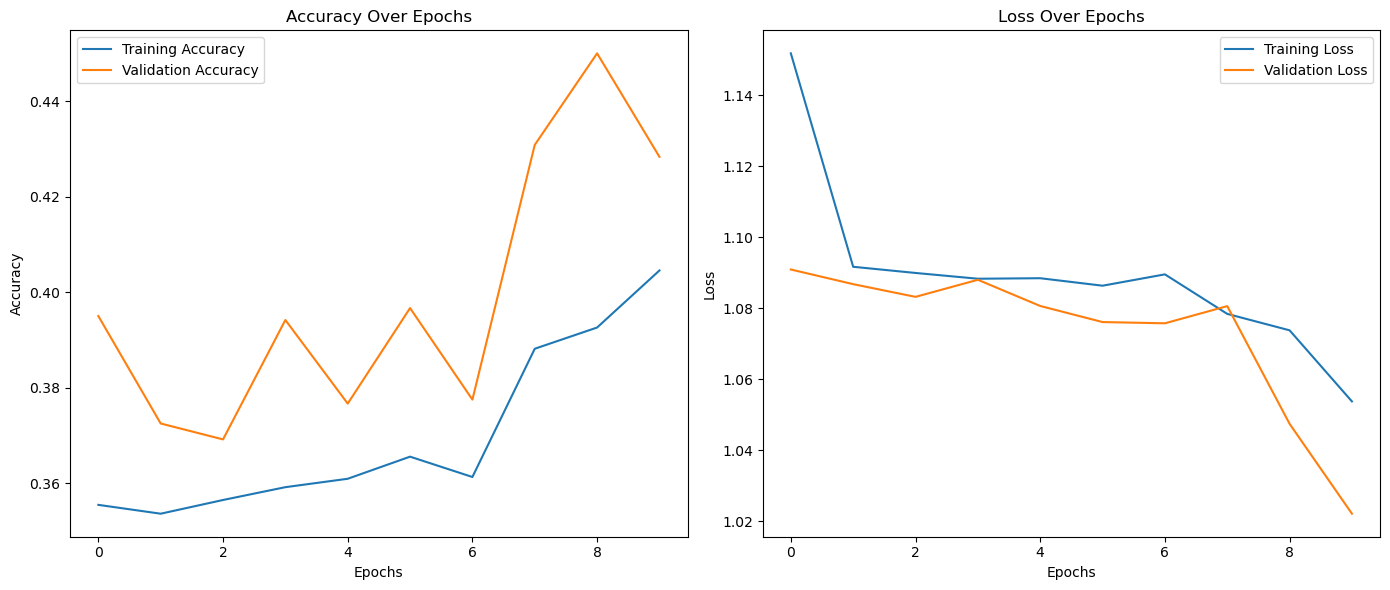

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False 

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(np.unique(y_train)), activation='softmax')(x)
resnet_model = Model(inputs=base_model.input, outputs=output)


resnet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history_resnet = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


def plot_training_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].plot(history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy Over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss Over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history_resnet)


##### Visulization of ROC, Precision-Recall curve and Confusion Matrix for ResNet50

94/94 [==============================] - 51s 533ms/step


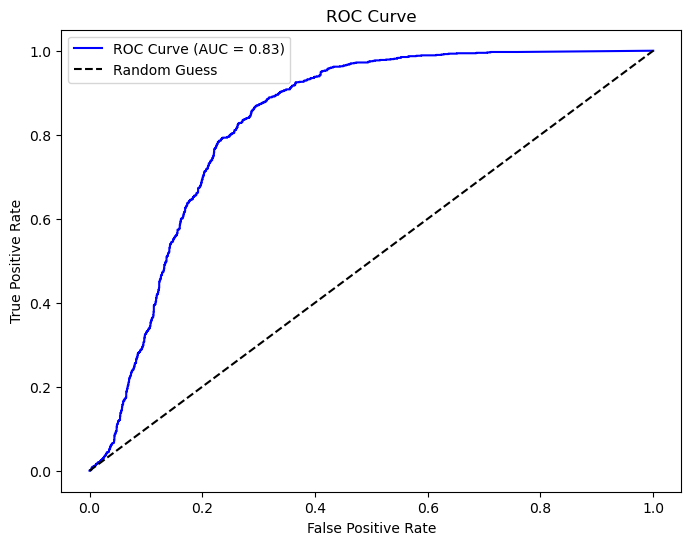

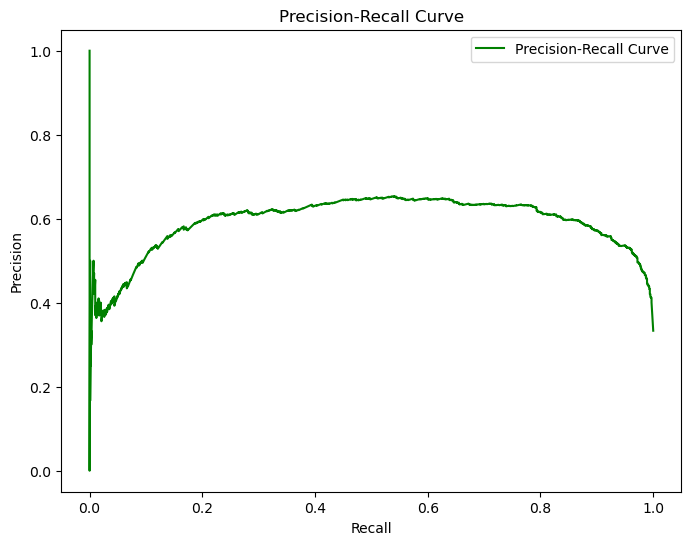

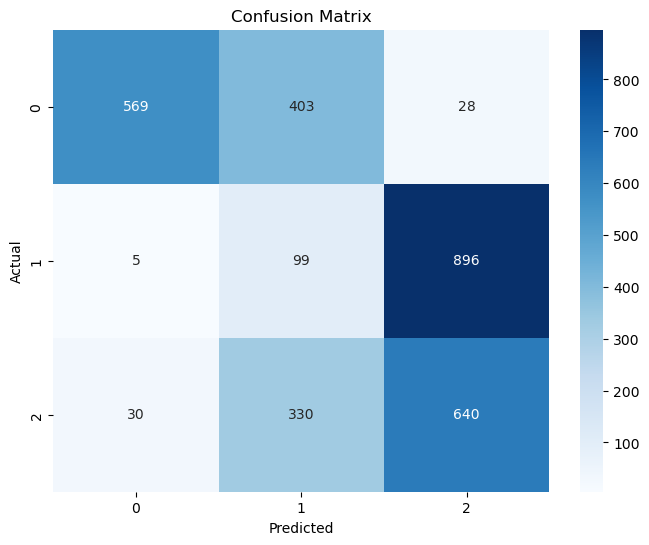

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1000
           1       0.12      0.10      0.11      1000
           2       0.41      0.64      0.50      1000

    accuracy                           0.44      3000
   macro avg       0.49      0.44      0.44      3000
weighted avg       0.49      0.44      0.44      3000



In [11]:
y_pred_proba = resnet_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1], pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print("Classification Report:")
print(classification_report(y_test, y_pred))


#### CNN model

Epoch 1/10
338/338 [==============================] - 70s 207ms/step - loss: 0.3570 - accuracy: 0.8511 - val_loss: 0.3125 - val_accuracy: 0.8700
Epoch 2/10
338/338 [==============================] - 69s 205ms/step - loss: 0.1853 - accuracy: 0.9267 - val_loss: 0.1891 - val_accuracy: 0.9367
Epoch 3/10
338/338 [==============================] - 69s 204ms/step - loss: 0.1166 - accuracy: 0.9530 - val_loss: 0.2764 - val_accuracy: 0.9075
Epoch 4/10
338/338 [==============================] - 69s 205ms/step - loss: 0.1015 - accuracy: 0.9627 - val_loss: 0.1715 - val_accuracy: 0.9417
Epoch 5/10
338/338 [==============================] - 69s 204ms/step - loss: 0.0599 - accuracy: 0.9776 - val_loss: 0.2381 - val_accuracy: 0.9283
Epoch 6/10
338/338 [==============================] - 69s 204ms/step - loss: 0.0640 - accuracy: 0.9763 - val_loss: 0.1903 - val_accuracy: 0.9617
Epoch 7/10
338/338 [==============================] - 69s 204ms/step - loss: 0.0271 - accuracy: 0.9905 - val_loss: 0.2762 - val_ac

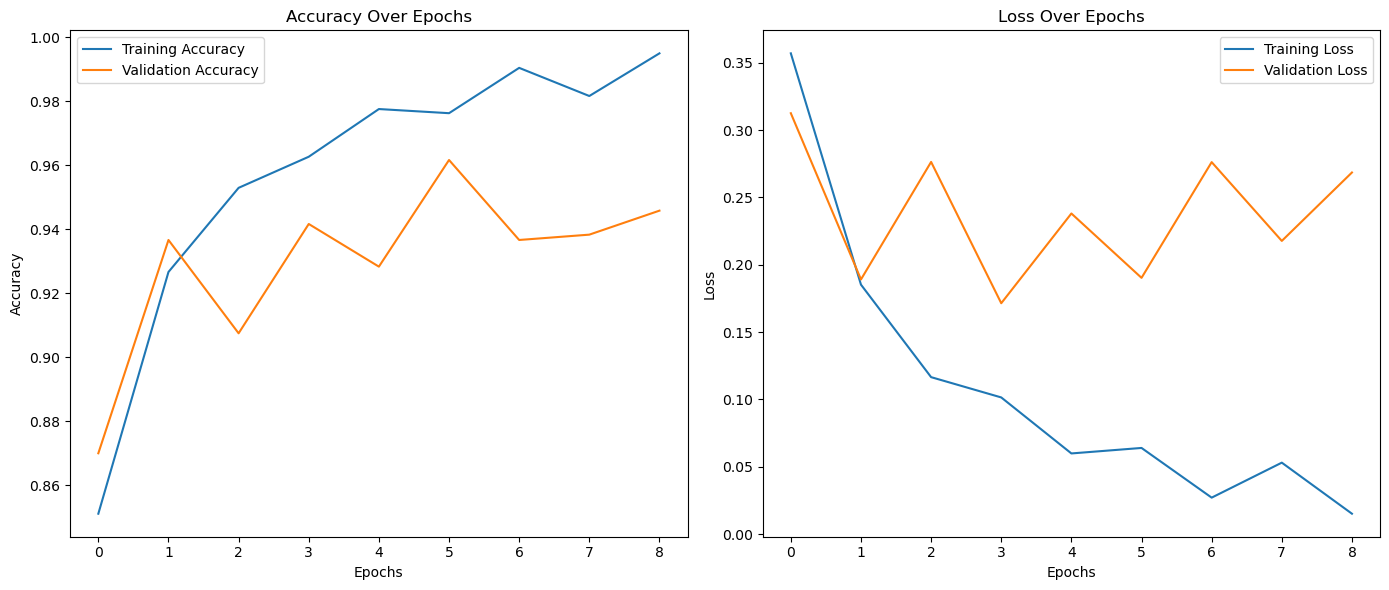

94/94 [==============================] - 6s 63ms/step


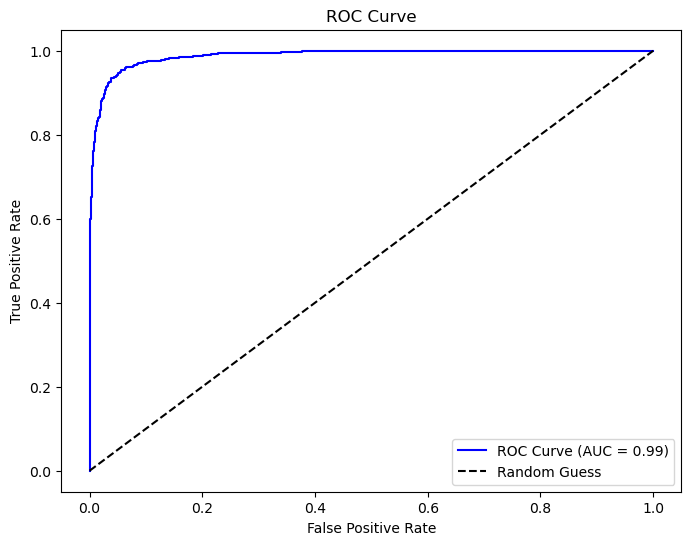

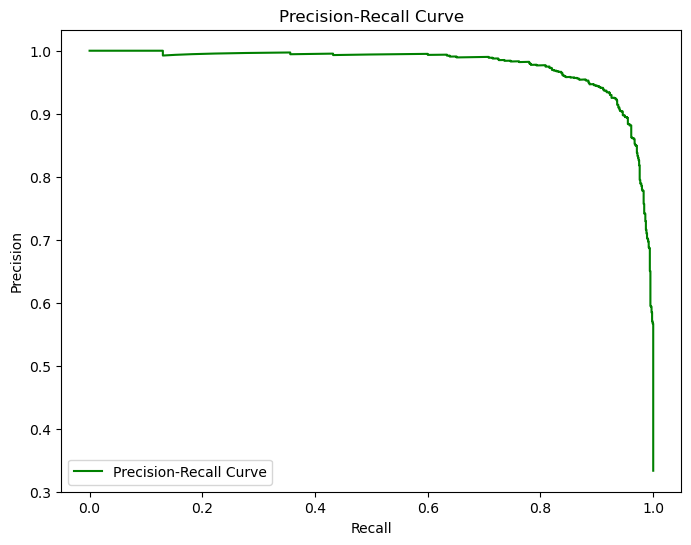

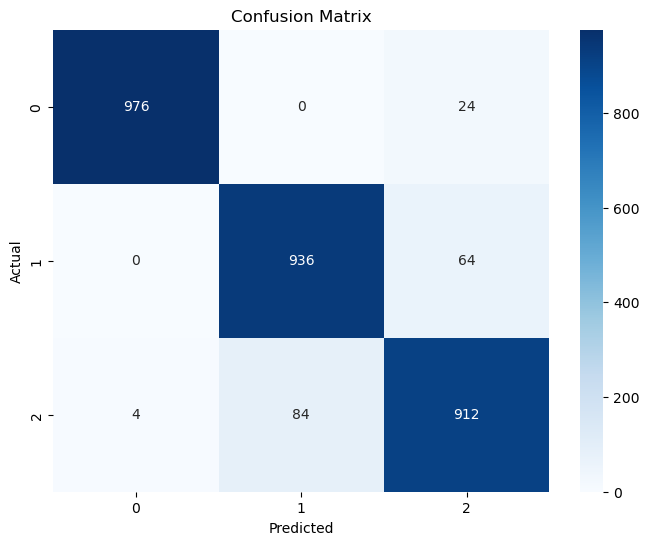

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1000
           1       0.92      0.94      0.93      1000
           2       0.91      0.91      0.91      1000

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [12]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

plot_training_curves(history_cnn)

y_pred_proba_cnn = cnn_model.predict(X_test)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_cnn[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_cnn[:, 1], pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_cnn))

#### CNN with Grayscale images

Train shape: (10800, 128, 128, 1), Validation shape: (1200, 128, 128, 1), Test shape: (3000, 128, 128, 1)
Epoch 1/10
675/675 [==============================] - 26s 38ms/step - loss: 1.0170 - accuracy: 0.4793 - val_loss: 0.9219 - val_accuracy: 0.5475
Epoch 2/10
675/675 [==============================] - 25s 38ms/step - loss: 0.7882 - accuracy: 0.6462 - val_loss: 0.8172 - val_accuracy: 0.6408
Epoch 3/10
675/675 [==============================] - 25s 37ms/step - loss: 0.4810 - accuracy: 0.8129 - val_loss: 0.9484 - val_accuracy: 0.6308
Epoch 4/10
675/675 [==============================] - 25s 37ms/step - loss: 0.2371 - accuracy: 0.9171 - val_loss: 1.1306 - val_accuracy: 0.6567
Epoch 5/10
675/675 [==============================] - 25s 37ms/step - loss: 0.1291 - accuracy: 0.9598 - val_loss: 1.1527 - val_accuracy: 0.6517
Epoch 6/10
675/675 [==============================] - 26s 38ms/step - loss: 0.0791 - accuracy: 0.9739 - val_loss: 1.3500 - val_accuracy: 0.6492
Epoch 7/10
675/675 [==========

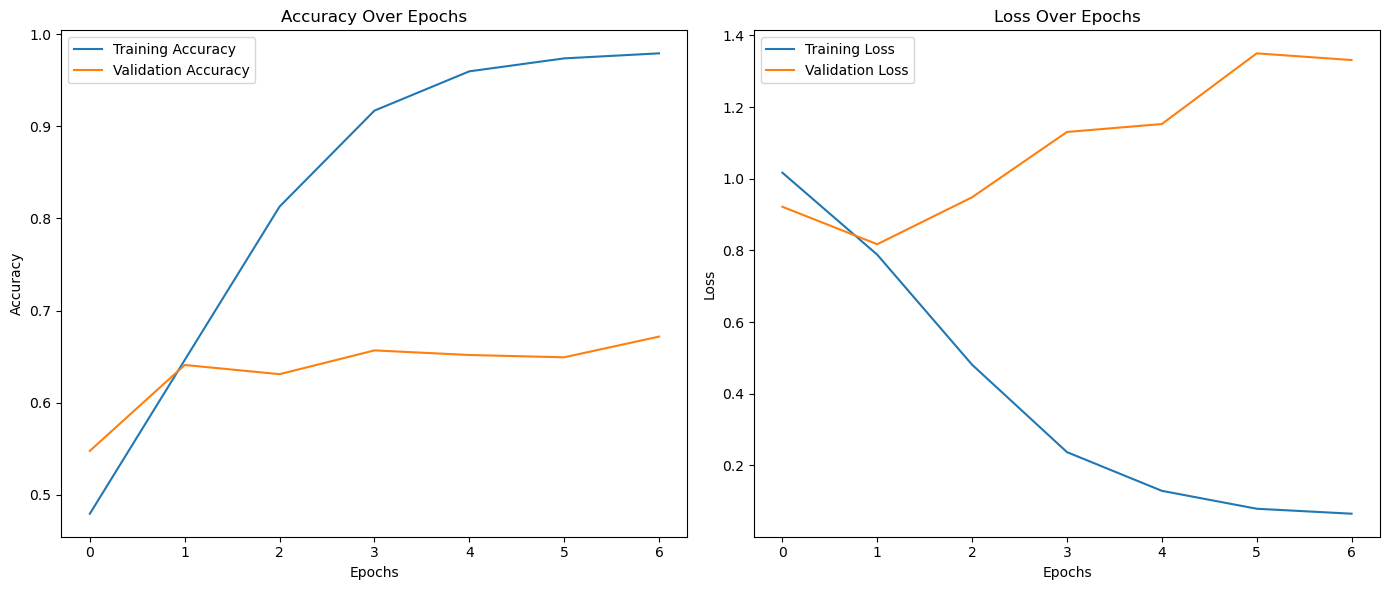

94/94 [==============================] - 3s 26ms/step


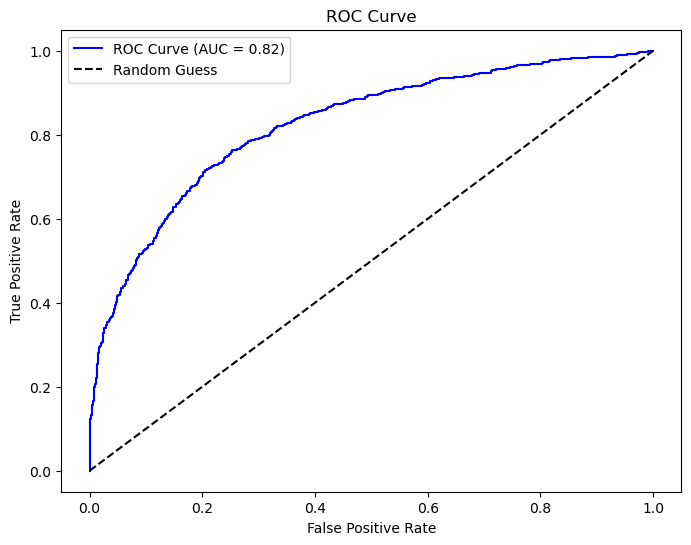

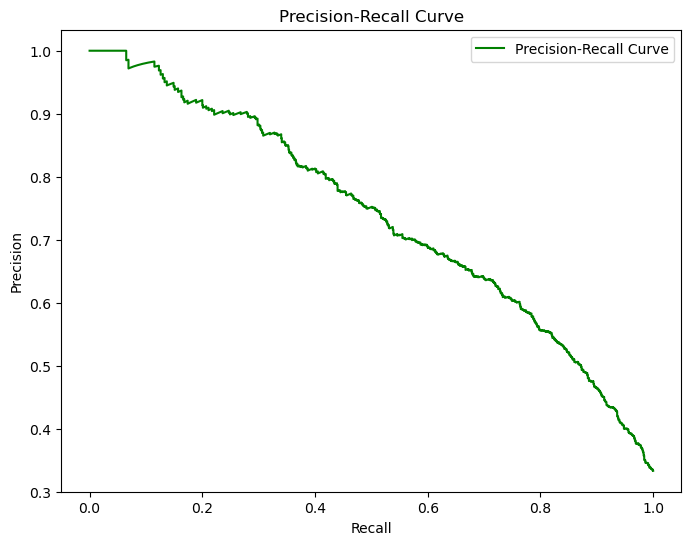

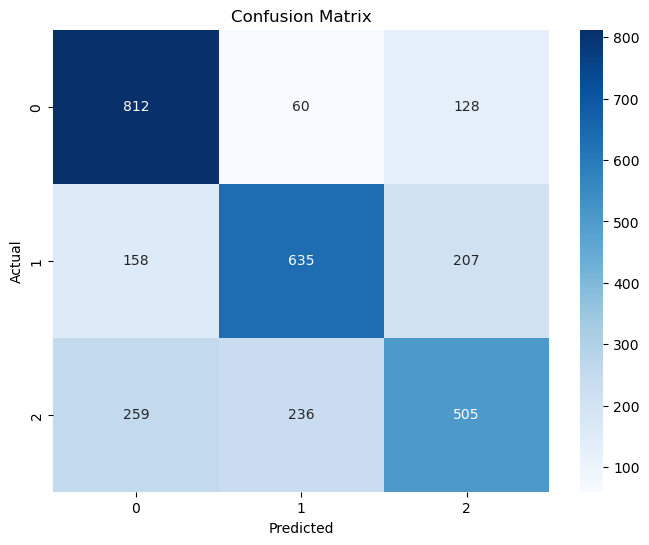

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      1000
           1       0.68      0.64      0.66      1000
           2       0.60      0.51      0.55      1000

    accuracy                           0.65      3000
   macro avg       0.65      0.65      0.65      3000
weighted avg       0.65      0.65      0.65      3000



In [15]:

image_size = (128, 128)
batch_size = 16
threshold = 0.5

def preprocess_images_in_batches(images, batch_size=1000):
    processed_images = []
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        batch = images[i * batch_size:(i + 1) * batch_size]
        batch_resized = tf.image.resize(batch, image_size)
        batch_gray = tf.image.rgb_to_grayscale(batch_resized)
        batch_bw = tf.cast(batch_gray > threshold, tf.float32)
        processed_images.append(batch_bw)
    
    return tf.concat(processed_images, axis=0)

X_train_bw = preprocess_images_in_batches(X_train, batch_size=1000)
X_val_bw = preprocess_images_in_batches(X_val, batch_size=1000)
X_test_bw = preprocess_images_in_batches(X_test, batch_size=1000)


print(f"Train shape: {X_train_bw.shape}, Validation shape: {X_val_bw.shape}, Test shape: {X_test_bw.shape}")



cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_cnn_bw = cnn_model.fit(
    X_train_bw, y_train,
    validation_data=(X_val_bw, y_val),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stop]
)

def plot_training_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy Over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    
    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss Over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history_cnn_bw)


y_pred_proba_bw = cnn_model.predict(X_test_bw)
y_pred_bw = tf.argmax(y_pred_proba_bw, axis=1).numpy()


fpr, tpr, _ = roc_curve(y_test, y_pred_proba_bw[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_bw[:, 1], pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


conf_matrix = confusion_matrix(y_test, y_pred_bw)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print("Classification Report:")
print(classification_report(y_test, y_pred_bw))


#### Model Comparison Before Hyperparameter Tuning

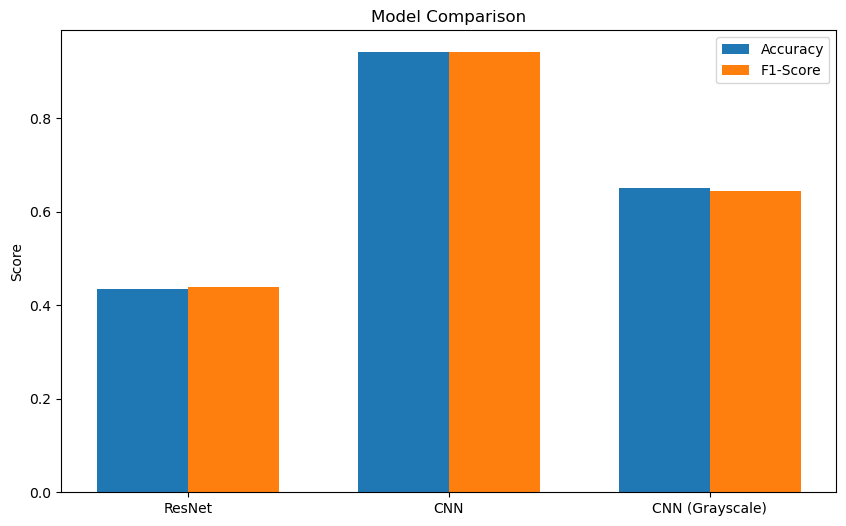

In [16]:
models = ['ResNet', 'CNN', 'CNN (Grayscale)']
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_cnn),
    accuracy_score(y_test, y_pred_bw)
]
f1_scores = [
    f1_score(y_test, y_pred, average='weighted'),
    f1_score(y_test, y_pred_cnn, average='weighted'),
    f1_score(y_test, y_pred_bw, average='weighted')
]

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Accuracy')
plt.bar(x + width/2, f1_scores, width, label='F1-Score')
plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Model Comparison')
plt.legend()
plt.show()


### Hyperparameter Tuning

In [19]:
from keras_tuner.tuners import RandomSearch


input_shape = X_train.shape[1:] 
num_classes = len(np.unique(y_train)) 


def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        hp.Int('filters_1', min_value=32, max_value=128, step=32),  
        (3, 3), activation='relu', input_shape=input_shape
    ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Flatten())
    model.add(Dense(
        hp.Int('units', min_value=128, max_value=512, step=128),  
        activation='relu'
    ))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of executions for each trial
    directory='hyperparameter_tuning',  # Directory to save tuning results
    project_name='lung_cancer_classification_tuning'
)

# Start the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"""
The optimal number of filters in the first convolutional layer is {best_hps.get('filters_1')}.
The optimal dropout rate is {best_hps.get('dropout')}.
The optimal number of units in the dense layer is {best_hps.get('units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the final model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Summary of the best model
best_model.summary()

Trial 10 Complete [00h 38m 28s]
val_accuracy: 0.7574999928474426

Best val_accuracy So Far: 0.9333333373069763
Total elapsed time: 04h 41m 01s

The optimal number of filters in the first convolutional layer is 32.
The optimal dropout rate is 0.2.
The optimal number of units in the dense layer is 256.
The optimal learning rate for the optimizer is 0.0001.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 flatten_1 (Flatten)      

#### ResNet50 with tuned parameters

Epoch 1/10
338/338 [==============================] - 307s 906ms/step - loss: 1.0830 - accuracy: 0.4938 - val_loss: 0.9462 - val_accuracy: 0.6008
Epoch 2/10
338/338 [==============================] - 254s 752ms/step - loss: 0.8803 - accuracy: 0.6074 - val_loss: 0.7799 - val_accuracy: 0.7050
Epoch 3/10
338/338 [==============================] - 256s 758ms/step - loss: 0.7611 - accuracy: 0.6775 - val_loss: 0.6806 - val_accuracy: 0.7575
Epoch 4/10
338/338 [==============================] - 340s 1s/step - loss: 0.6766 - accuracy: 0.7129 - val_loss: 0.6063 - val_accuracy: 0.7300
Epoch 5/10
338/338 [==============================] - 396s 1s/step - loss: 0.6240 - accuracy: 0.7332 - val_loss: 0.5537 - val_accuracy: 0.7858
Epoch 6/10
338/338 [==============================] - 390s 1s/step - loss: 0.5889 - accuracy: 0.7478 - val_loss: 0.5521 - val_accuracy: 0.7758
Epoch 7/10
338/338 [==============================] - 382s 1s/step - loss: 0.5579 - accuracy: 0.7640 - val_loss: 0.5713 - val_accurac

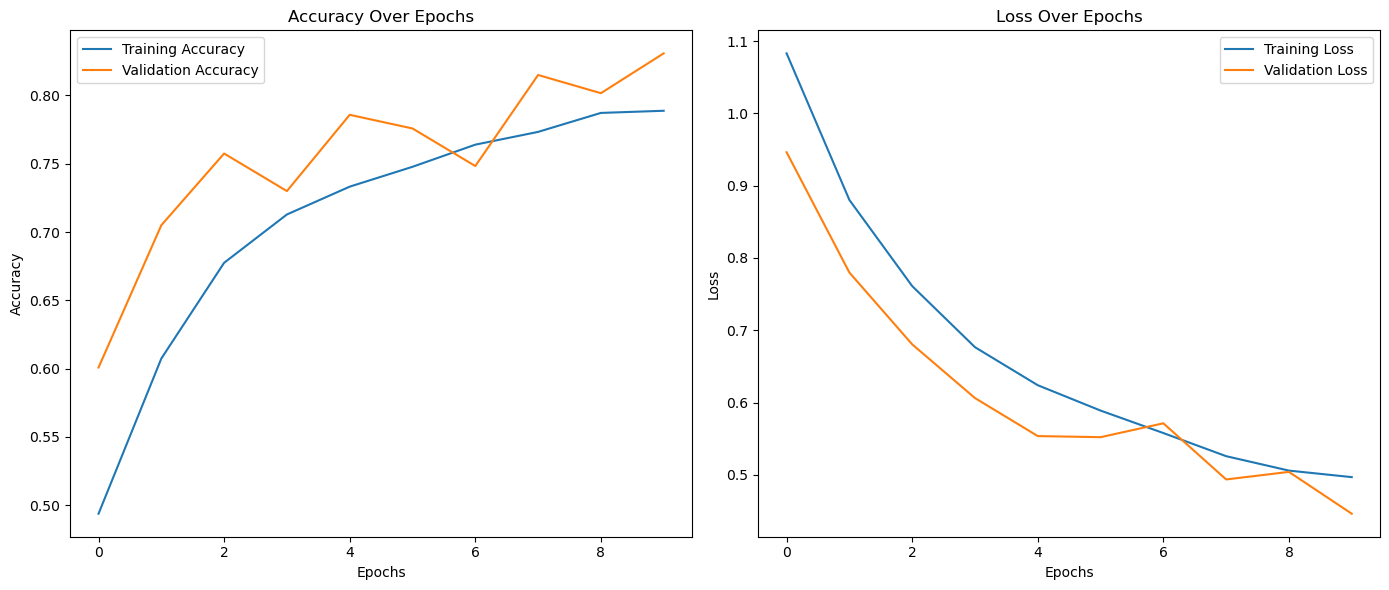

In [17]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  


x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  
x = Dropout(0.2)(x)  
output = Dense(len(np.unique(y_train)), activation='softmax')(x)
resnet_model = Model(inputs=base_model.input, outputs=output)
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_resnet = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,  
    callbacks=[early_stop]
)

def plot_training_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].plot(history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy Over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    
    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss Over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history_resnet)


94/94 [==============================] - 51s 536ms/step


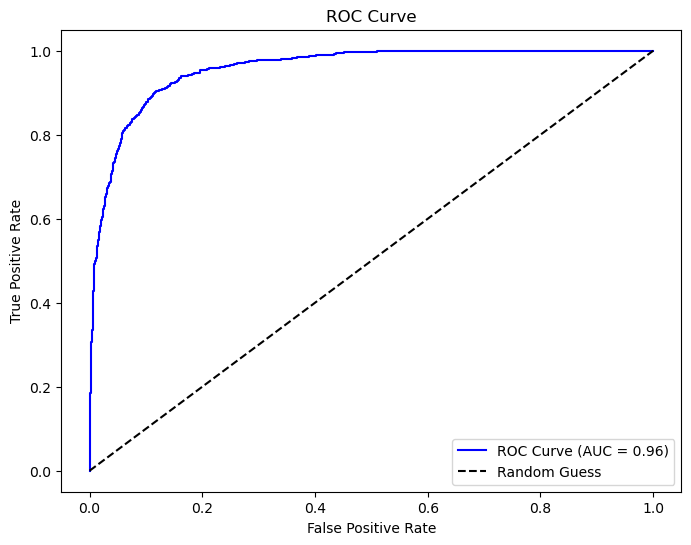

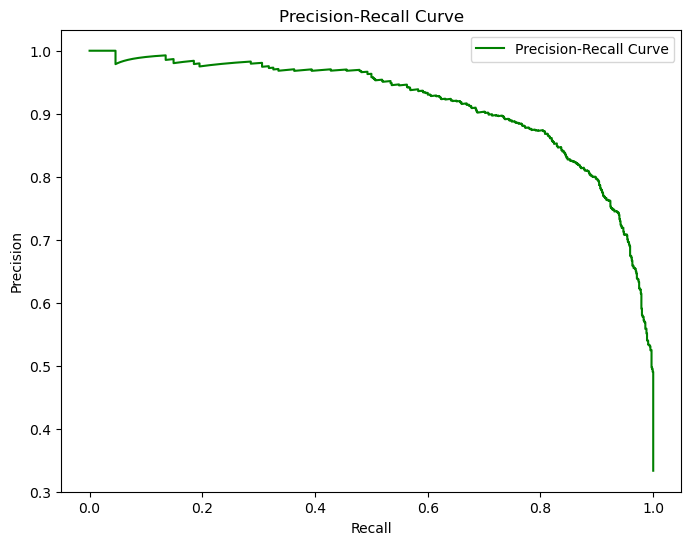

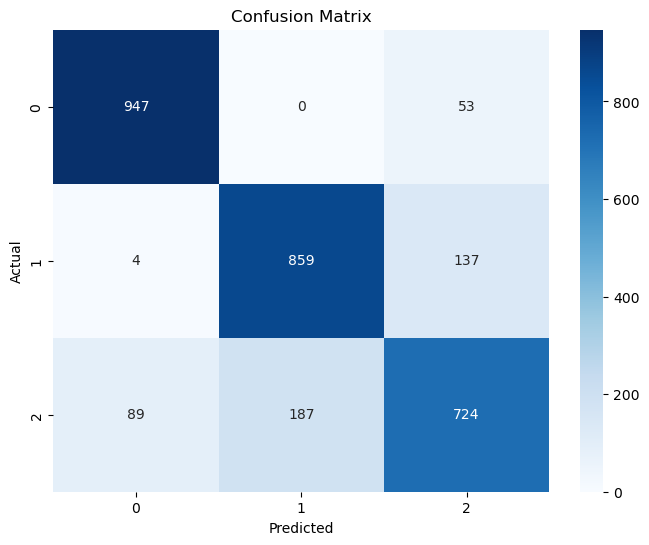

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1000
           1       0.82      0.86      0.84      1000
           2       0.79      0.72      0.76      1000

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [18]:
y_pred_proba = resnet_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1], pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))


#### CNN with tuned parameters

Epoch 1/10
338/338 [==============================] - 139s 407ms/step - loss: 0.5022 - accuracy: 0.7581 - val_loss: 0.3531 - val_accuracy: 0.8417
Epoch 2/10
338/338 [==============================] - 170s 505ms/step - loss: 0.3282 - accuracy: 0.8552 - val_loss: 0.2964 - val_accuracy: 0.8825
Epoch 3/10
338/338 [==============================] - 226s 668ms/step - loss: 0.2649 - accuracy: 0.8881 - val_loss: 0.2581 - val_accuracy: 0.8892
Epoch 4/10
338/338 [==============================] - 201s 595ms/step - loss: 0.2131 - accuracy: 0.9157 - val_loss: 0.2275 - val_accuracy: 0.9108
Epoch 5/10
338/338 [==============================] - 53s 158ms/step - loss: 0.1772 - accuracy: 0.9316 - val_loss: 0.2064 - val_accuracy: 0.9192
Epoch 6/10
338/338 [==============================] - 52s 153ms/step - loss: 0.1470 - accuracy: 0.9422 - val_loss: 0.2184 - val_accuracy: 0.9208
Epoch 7/10
338/338 [==============================] - 52s 154ms/step - loss: 0.1239 - accuracy: 0.9530 - val_loss: 0.1894 - va

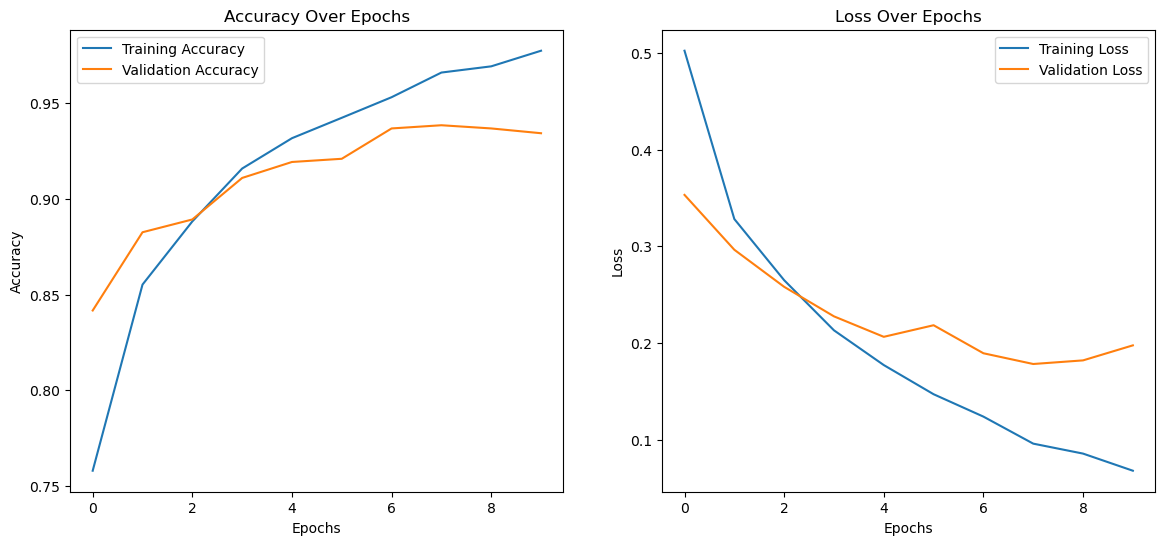

94/94 [==============================] - 4s 38ms/step


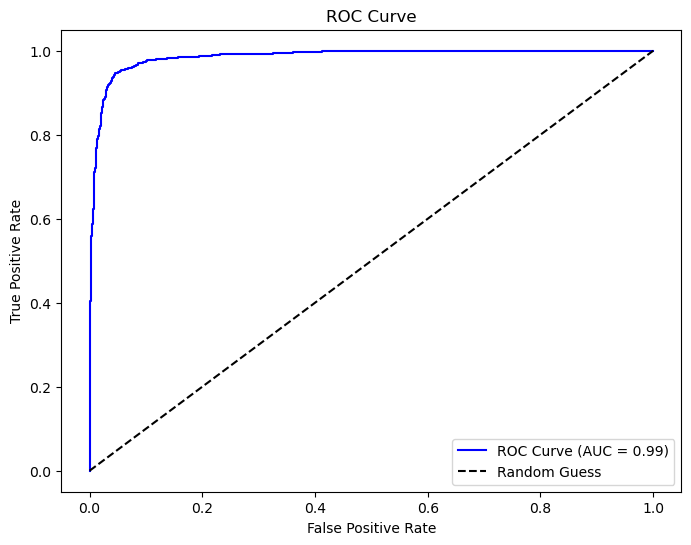

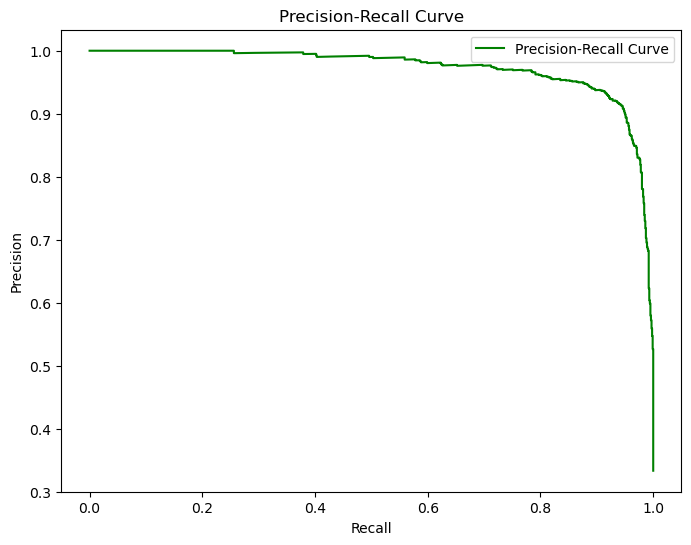

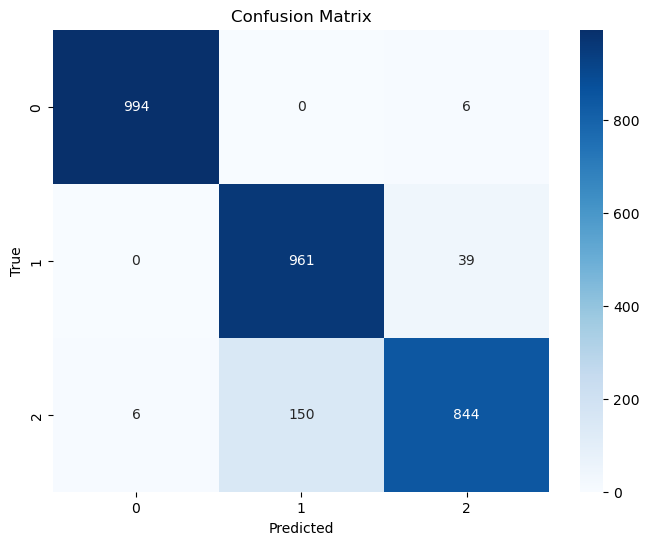

In [10]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') 
])


cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

def plot_training_curves(history):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_curves(history_cnn)


y_pred_proba_cnn = cnn_model.predict(X_test)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_cnn[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_cnn[:, 1], pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


conf_matrix = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
print("Classification Report:")
print(classification_report(y_test, y_pred_cnn))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.86      0.96      0.91      1000
           2       0.95      0.84      0.89      1000

    accuracy                           0.93      3000
   macro avg       0.94      0.93      0.93      3000
weighted avg       0.94      0.93      0.93      3000



#### CNN-Grayscale with tuned parameters

Train shape: (10800, 128, 128, 1), Validation shape: (1200, 128, 128, 1), Test shape: (3000, 128, 128, 1)
Epoch 1/10
675/675 [==============================] - 33s 48ms/step - loss: 1.0079 - accuracy: 0.4653 - val_loss: 0.9268 - val_accuracy: 0.5317
Epoch 2/10
675/675 [==============================] - 29s 43ms/step - loss: 0.9114 - accuracy: 0.5466 - val_loss: 0.8890 - val_accuracy: 0.5492
Epoch 3/10
675/675 [==============================] - 29s 43ms/step - loss: 0.8431 - accuracy: 0.6054 - val_loss: 0.8481 - val_accuracy: 0.6200
Epoch 4/10
675/675 [==============================] - 29s 43ms/step - loss: 0.7578 - accuracy: 0.6588 - val_loss: 0.7821 - val_accuracy: 0.6517
Epoch 5/10
675/675 [==============================] - 29s 43ms/step - loss: 0.6751 - accuracy: 0.7073 - val_loss: 0.8055 - val_accuracy: 0.6400
Epoch 6/10
675/675 [==============================] - 31s 47ms/step - loss: 0.6007 - accuracy: 0.7487 - val_loss: 0.7264 - val_accuracy: 0.6767
Epoch 7/10
675/675 [==========

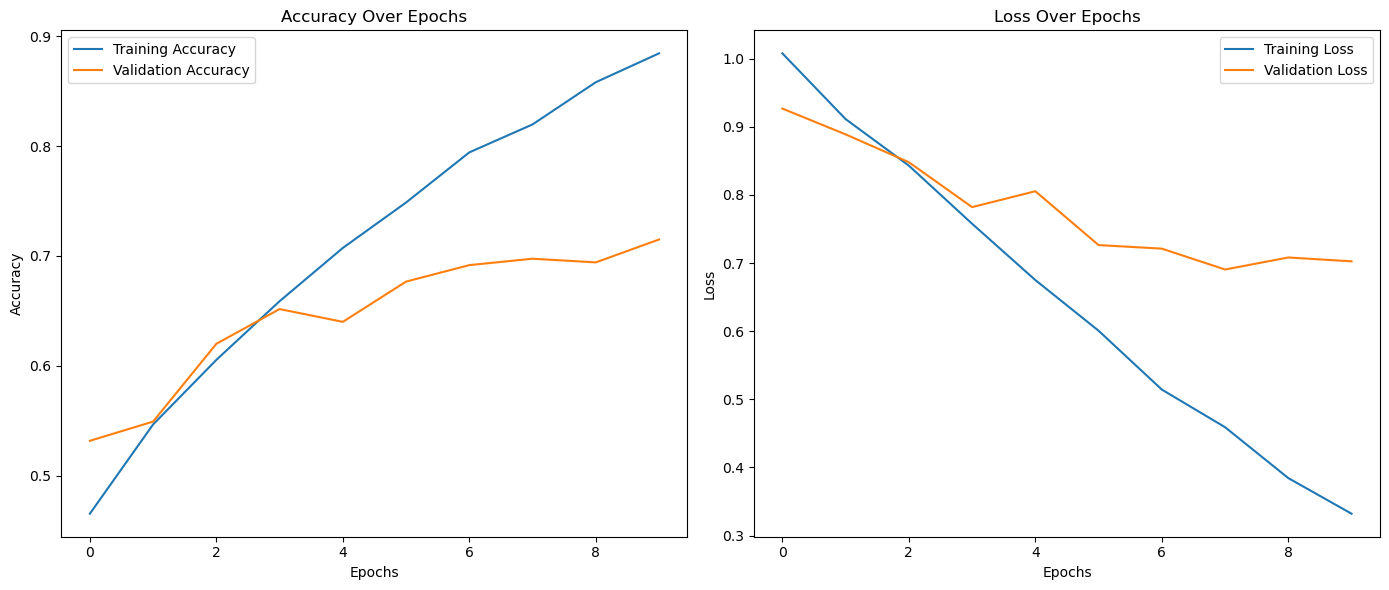

94/94 [==============================] - 2s 18ms/step


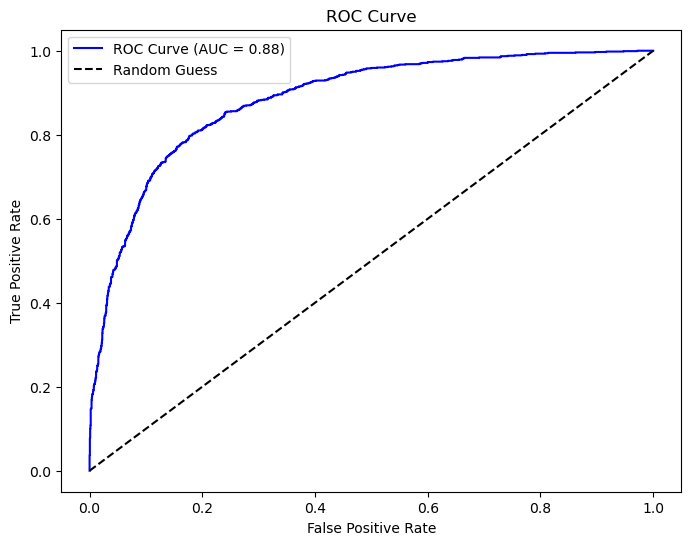

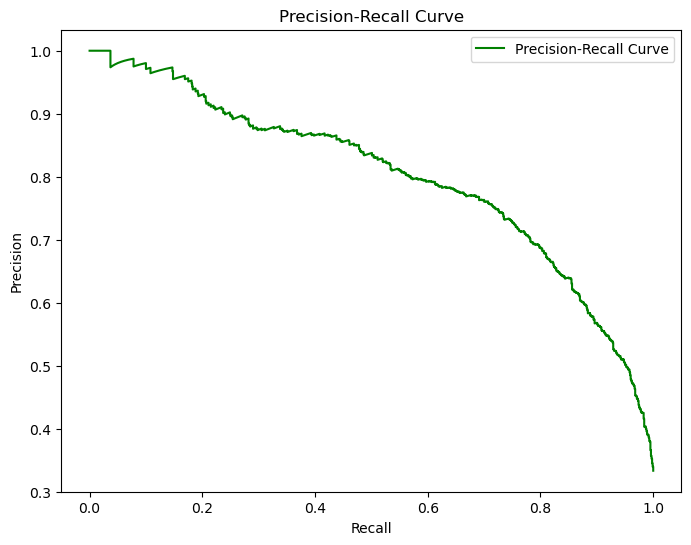

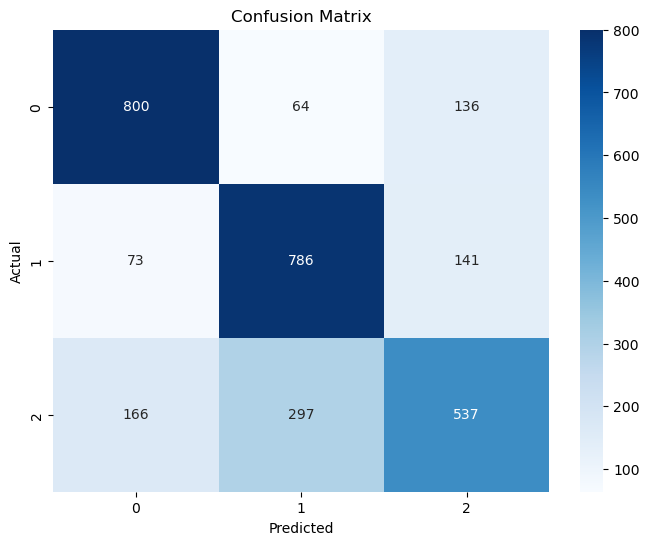

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1000
           1       0.69      0.79      0.73      1000
           2       0.66      0.54      0.59      1000

    accuracy                           0.71      3000
   macro avg       0.70      0.71      0.70      3000
weighted avg       0.70      0.71      0.70      3000



In [20]:
image_size = (128, 128)
batch_size = 16
threshold = 0.5  

def preprocess_images_in_batches(images, batch_size=1000):

    processed_images = []
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        batch = images[i * batch_size:(i + 1) * batch_size]
        batch_resized = tf.image.resize(batch, image_size)
        batch_gray = tf.image.rgb_to_grayscale(batch_resized)
        batch_bw = tf.cast(batch_gray > threshold, tf.float32)
        processed_images.append(batch_bw)
    
    return tf.concat(processed_images, axis=0)


X_train_bw = preprocess_images_in_batches(X_train, batch_size=1000)
X_val_bw = preprocess_images_in_batches(X_val, batch_size=1000)
X_test_bw = preprocess_images_in_batches(X_test, batch_size=1000)

print(f"Train shape: {X_train_bw.shape}, Validation shape: {X_val_bw.shape}, Test shape: {X_test_bw.shape}")

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1)),  
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'), 
    Dropout(0.2), 
    Dense(3, activation='softmax')  
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_cnn_bw = cnn_model.fit(
    X_train_bw, y_train,
    validation_data=(X_val_bw, y_val),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stop]
)


def plot_training_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    

    ax[0].plot(history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy Over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    
    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss Over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history_cnn_bw)


y_pred_proba_bw = cnn_model.predict(X_test_bw)
y_pred_bw = tf.argmax(y_pred_proba_bw, axis=1).numpy()
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_bw[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_bw[:, 1], pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


conf_matrix = confusion_matrix(y_test, y_pred_bw)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_bw))



#### Model Comparison (tuned parameters models)

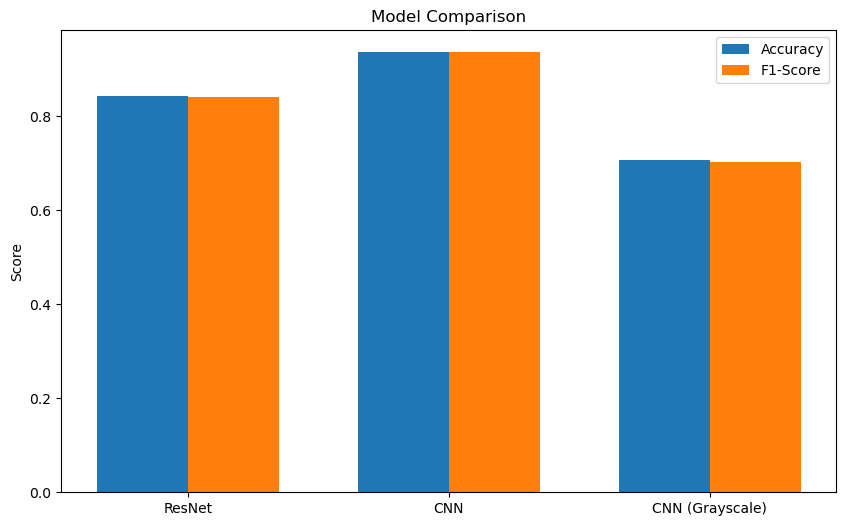

In [21]:
from sklearn.metrics import accuracy_score, f1_score

models = ['ResNet', 'CNN', 'CNN (Grayscale)']
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_cnn),
    accuracy_score(y_test, y_pred_bw)
]
f1_scores = [
    f1_score(y_test, y_pred, average='weighted'),
    f1_score(y_test, y_pred_cnn, average='weighted'),
    f1_score(y_test, y_pred_bw, average='weighted')
]

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Accuracy')
plt.bar(x + width/2, f1_scores, width, label='F1-Score')
plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Model Comparison')
plt.legend()
plt.show()